In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import model_selection, preprocessing, metrics
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from utils import classification_util as cu
from nn_framework import *

## Load Data

In [75]:
data_path = r'/home/david/TU/ML/Loan/Data/loan-10k.lrn.csv'
df = pd.read_csv(data_path)
df

,ID,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,...,debt_settlement_flag,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year,grade
0,24341,12500.0,12500.0,12500.0,36 months,7.21,387.17,< 1 year,MORTGAGE,81000.0,...,N,6,2018,6,2000,2,2019,2,2019,A
1,67534,33850.0,33850.0,33775.0,60 months,20.99,915.57,1 year,MORTGAGE,80000.0,...,N,10,2015,9,1984,2,2019,2,2019,E
2,35080,10000.0,10000.0,10000.0,60 months,20.00,264.94,< 1 year,RENT,36580.0,...,N,9,2017,10,2006,1,2018,11,2018,D
3,4828,20250.0,20250.0,20250.0,36 months,14.31,695.15,9 years,RENT,48700.0,...,N,0,2015,6,1996,6,2016,9,2017,C
4,59259,25000.0,25000.0,25000.0,36 months,14.99,866.52,1 year,MORTGAGE,85000.0,...,N,11,2016,0,2002,2,2019,2,2019,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,6644,20000.0,20000.0,20000.0,60 months,16.02,486.58,5 years,OWN,54000.0,...,N,8,2017,11,1991,2,2019,2,2019,C
9996,25910,7500.0,7500.0,7500.0,36 months,9.49,240.22,10+ years,RENT,46386.0,...,N,10,2014,4,2004,3,2017,6,2018,B
9997,95698,20750.0,20750.0,20750.0,60 months,15.05,494.19,< 1 year,RENT,185000.0,...,N,4,2017,2,2004,2,2019,2,2019,C
9998,27371,11000.0,11000.0,11000.0,60 months,16.29,269.20,1 year,RENT,38500.0,...,N,9,2014,8,2006,3,2016,10,2016,D


## Experiments

In [76]:
def transformer(X):
        log_tranform_col = ['int_rate', 'annual_inc', 'total_rev_hi_lim', 'tot_hi_cred_lim', 'total_bc_limit']
        c_root_tranform_col = ['installment', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 
                            'total_il_high_credit_limit', 'total_bal_ex_mort', 'avg_cur_bal', 'bc_open_to_buy', 
                            'revol_bal', 'total_rec_int', 'last_pymnt_amnt', 'tot_coll_amt','tot_cur_bal']

        for col in c_root_tranform_col:
            X[col] = np.cbrt(X[col])
        for col in log_tranform_col:
            X[col] = np.log(X[col])
        return X

In [77]:
def train_test(X, y):
    X_tr, X_te, y_tr, y_te = train_test_split(X,y, random_state=40, stratify=y, test_size=0.2)
    # X_te_id = X_te.pop('ID')
    # X_tr_id = X_tr.pop('ID')
    return X_tr, X_te, y_tr, y_te#, X_te_id, X_tr_id

In [78]:
nn = NNFramework()
data = df.copy()

In [79]:
y = data.pop('grade')
X = data
X = transformer(X)
cols = list(X.select_dtypes('object').columns)
nn.fit_encoder(X, cols)
X = nn.encode_dataset(X)

In [80]:
random_seed = 1038
scaling = True
oversampling = True

scaler = preprocessing.StandardScaler() if scaling else None

In [81]:
methods = [
        ('MLP-relu-1-5', MLP(activation_function='relu', hidden_layer_sizes=(5,))),
        ('MLP-sigmoid-1-5', MLP(activation_function='sigmoid', hidden_layer_sizes=(5,))),
        ('MLP-relu-1-10', MLP(activation_function='relu', hidden_layer_sizes=(10,))),
        ('MLP-sigmoid-1-10', MLP(activation_function='sigmoid', hidden_layer_sizes=(10,))),
        ('MLP-relu-1-40', MLP(activation_function='relu', hidden_layer_sizes=(40,))),
        ('MLP-sigmoid-1-40', MLP(activation_function='sigmoid', hidden_layer_sizes=(40,))),
        ('MLP-relu-2-10', MLP(activation_function='relu', hidden_layer_sizes=(10, 10))),
        ('MLP-sigmoid-2-10', MLP(activation_function='sigmoid', hidden_layer_sizes=(10, 10))),
        ('MLP-relu-2-40', MLP(activation_function='relu', hidden_layer_sizes=(40, 40))),
        ('MLP-sigmoid-2-40', MLP(activation_function='sigmoid', hidden_layer_sizes=(40, 40))),
        ('MLP-relu-5-10', MLP(activation_function='relu', hidden_layer_sizes=(10, 10, 10, 10, 10))),
        ('MLP-sigmoid-5-10', MLP(activation_function='sigmoid', hidden_layer_sizes=(10, 10, 10, 10, 10))),
    ]
    
pipelines = cu.define_pipelines(methods, scaler=scaler, oversampling=oversampling)

In [82]:


model_params = {}
for model_name, pipeline in pipelines.items():
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='f1_macro', n_jobs=-1)

    model_params[model_name] = {}
    model_params[model_name]['f_scores'] = scores
    model_params[model_name]['f_scores_mean'] = scores.mean()
    model_params[model_name]['f_scores_std'] = scores.std()

    print(model_name)
    print(
        f"f1 scores: {model_params[model_name]['f_scores']}\n" +
        f"f1 mean: {model_params[model_name]['f_scores_mean']:.3f}\n" +
        f"f1 std: {model_params[model_name]['f_scores_std']:.3f}\n"
    )
    print('----------------------------------------------------------------------------------------------------')
    


/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:107: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:107: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:107: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:107: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])


ALARM, ALARM: divergence detected, use smaller learning rate you worthless piece of shit
As punishment we return the models with randomly initialized weights
ALARM, ALARM: divergence detected, use smaller learning rate you worthless piece of shit
As punishment we return the models with randomly initialized weights


/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:107: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:107: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:107: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:107: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:107: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:107: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])


ALARM, ALARM: divergence detected, use smaller learning rate you worthless piece of shit
As punishment we return the models with randomly initialized weights
ALARM, ALARM: divergence detected, use smaller learning rate you worthless piece of shit
As punishment we return the models with randomly initialized weights
ALARM, ALARM: divergence detected, use smaller learning rate you worthless piece of shit
As punishment we return the models with randomly initialized weights
MLP-relu-1-5
f1 scores: [0.07706551 0.07703796 0.06917605 0.08164018 0.07798333]
f1 mean: 0.077
f1 std: 0.004

----------------------------------------------------------------------------------------------------
MLP-sigmoid-1-5
f1 scores: [0.60994814 0.59442095 0.59997918 0.62037339 0.625575  ]
f1 mean: 0.610
f1 std: 0.012

----------------------------------------------------------------------------------------------------


/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:107: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:107: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:107: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:107: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:107: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:107: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:107: RuntimeWarning: overflow e

ALARM, ALARM: divergence detected, use smaller learning rate you worthless piece of shit
As punishment we return the models with randomly initialized weights
ALARM, ALARM: divergence detected, use smaller learning rate you worthless piece of shit
As punishment we return the models with randomly initialized weights
ALARM, ALARM: divergence detected, use smaller learning rate you worthless piece of shit
As punishment we return the models with randomly initialized weights
ALARM, ALARM: divergence detected, use smaller learning rate you worthless piece of shit
As punishment we return the models with randomly initialized weights
ALARM, ALARM: divergence detected, use smaller learning rate you worthless piece of shit
As punishment we return the models with randomly initialized weights
MLP-relu-1-10
f1 scores: [0.06224794 0.06285006 0.06876214 0.05982375 0.06381683]
f1 mean: 0.064
f1 std: 0.003

--------------------------------------------------------------------------------------------------

KeyboardInterrupt: 

In [18]:
df_param = pd.DataFrame(model_params).transpose()
df_param = df_param.reset_index(drop=False)
df_param = df_param.rename(columns={'index': 'model'})

df_param['activation_function'] = df_param.model.str.extract(r'MLP-(\w+)-.*')
df_param['layer_num'] = df_param.model.str.extract(r'MLP-\w+-(\d+).*')
df_param['layer_sizes'] = df_param.model.str.extract(r'MLP-\w+-\d-(\d+)')

df_param

Down below the parameter grids are defined fro the gridsearch

In [19]:
models = {}

In [22]:
knn_params = {'KNN__n_neighbors': [1, 2, 3, 5, 7, 10, 20, 30, 40, 50, 100, 200, 300, 1000, 2000, 5000], 
              'KNN__weights': ['distance'],
              'KNN__p': [1, 2],
             }
models['KNN'] = perform_gridsearch(X_tr, y_tr, X_te, y_te, pipelines['KNN'], knn_params, do_holdout)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END KNN__n_neighbors=1, KNN__p=1, KNN__weights=distance; total time=   1.5s
[CV] END KNN__n_neighbors=1, KNN__p=1, KNN__weights=distance; total time=   1.5s
[CV] END KNN__n_neighbors=1, KNN__p=1, KNN__weights=distance; total time=   1.5s
[CV] END KNN__n_neighbors=1, KNN__p=2, KNN__weights=distance; total time=   0.3s
[CV] END KNN__n_neighbors=1, KNN__p=2, KNN__weights=distance; total time=   0.3s
[CV] END KNN__n_neighbors=1, KNN__p=2, KNN__weights=distance; total time=   0.3s
[CV] END KNN__n_neighbors=1, KNN__p=2, KNN__weights=distance; total time=   0.3s
[CV] END KNN__n_neighbors=1, KNN__p=1, KNN__weights=distance; total time=   1.3s
[CV] END KNN__n_neighbors=1, KNN__p=1, KNN__weights=distance; total time=   1.5s
[CV] END KNN__n_neighbors=1, KNN__p=2, KNN__weights=distance; total time=   0.3s
[CV] END KNN__n_neighbors=2, KNN__p=1, KNN__weights=distance; total time=   1.2s
[CV] END KNN__n_neighbors=2, KNN__p=1, KNN__wei

{'KNN__n_neighbors': 5000, 'KNN__p': 1, 'KNN__weights': 'distance'}

0.06060433387756348

array([[324,  36,   3,   1,   0,   0,   0],
       [229, 242,  90,   5,   2,   2,   6],
       [ 93, 109, 289,  56,  14,  11,  26],
       [ 15,  19,  99,  85,  30,  21,  21],
       [  5,   2,  16,  39,  24,  14,  24],
       [  0,   0,   1,   8,   7,   6,  15],
       [  0,   0,   0,   2,   4,   1,   4]])

acc: 0.487
balanced_acc: 0.40085381887759786
prfs: (0.36295319542437665, 0.40085381887759786, 0.3482157304229382, None)



In [23]:
mlp_params = {
    'MLP__hidden_layer_sizes': [(50, 10), (50, 50), (30, 30), (20, 20), (40, 10)],
    'MLP__activation': ['relu'],
    'MLP__solver': ['adam'],
    'MLP__alpha': [0.0001, 0.001],
    'MLP__learning_rate': ['adaptive'],
    'MLP__max_iter': [500]
}

models['MLP'] = perform_gridsearch(X_tr, y_tr, X_te, y_te, pipelines['MLP'], mlp_params, do_holdout)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END MLP__activation=relu, MLP__alpha=0.0001, MLP__hidden_layer_sizes=(50, 10), MLP__learning_rate=adaptive, MLP__max_iter=500, MLP__solver=adam; total time=  11.9s
[CV] END MLP__activation=relu, MLP__alpha=0.0001, MLP__hidden_layer_sizes=(50, 10), MLP__learning_rate=adaptive, MLP__max_iter=500, MLP__solver=adam; total time=  12.4s
[CV] END MLP__activation=relu, MLP__alpha=0.0001, MLP__hidden_layer_sizes=(50, 10), MLP__learning_rate=adaptive, MLP__max_iter=500, MLP__solver=adam; total time=  15.4s
[CV] END MLP__activation=relu, MLP__alpha=0.0001, MLP__hidden_layer_sizes=(50, 10), MLP__learning_rate=adaptive, MLP__max_iter=500, MLP__solver=adam; total time=  11.5s
[CV] END MLP__activation=relu, MLP__alpha=0.0001, MLP__hidden_layer_sizes=(50, 10), MLP__learning_rate=adaptive, MLP__max_iter=500, MLP__solver=adam; total time=  11.8s
[CV] END MLP__activation=relu, MLP__alpha=0.0001, MLP__hidden_layer_sizes=(50, 50), MLP__learn

{'MLP__activation': 'relu',
 'MLP__alpha': 0.0001,
 'MLP__hidden_layer_sizes': (20, 20),
 'MLP__learning_rate': 'adaptive',
 'MLP__max_iter': 500,
 'MLP__solver': 'adam'}

68.39259934425354

array([[329,  35,   0,   0,   0,   0,   0],
       [ 21, 534,  21,   0,   0,   0,   0],
       [  1,  17, 554,  26,   0,   0,   0],
       [  0,   0,  21, 249,  19,   1,   0],
       [  0,   0,   0,  25,  85,  14,   0],
       [  0,   0,   0,   0,  15,  21,   1],
       [  0,   0,   0,   0,   1,   9,   1]])

acc: 0.8865
balanced_acc: 0.7085617301373335
prfs: (0.7547307053284331, 0.7085617301373335, 0.7105983278409722, None)



In [25]:
DT_params = {
    'DT__max_depth': [None, 5, 10, 20, 50, 100],
    'DT__min_samples_split': [2, 5, 10],
    'DT__min_samples_leaf': [1, 2, 4]
}

models['DT'] = perform_gridsearch(X_tr, y_tr, X_te, y_te, pipelines['DT'], DT_params, do_holdout)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=2; total time=   0.2s
[CV] END DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=2; total time=   0.2s
[CV] END DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=2; total time=   0.3s
[CV] END DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=2; total time=   0.2s
[CV] END DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=2; total time=   0.2s
[CV] END DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=5; total time=   0.2s
[CV] END DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=5; total time=   0.2s
[CV] END DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=5; total time=   0.2s
[CV] END DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=5; total time=   0.1s
[CV] END DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samp

{'DT__max_depth': 50, 'DT__min_samples_leaf': 2, 'DT__min_samples_split': 5}

0.1619253158569336

array([[362,   2,   0,   0,   0,   0,   0],
       [  2, 572,   2,   0,   0,   0,   0],
       [  1,   2, 595,   0,   0,   0,   0],
       [  0,   0,   3, 286,   1,   0,   0],
       [  0,   0,   0,   6, 116,   2,   0],
       [  0,   0,   0,   0,   3,  31,   3],
       [  0,   0,   0,   0,   0,   2,   9]])

acc: 0.9855
balanced_acc: 0.9371792501703065
prfs: (0.9369051501879291, 0.9371792501703065, 0.9366966281394529, None)



## Kaggle classification

In [36]:
if kaggle:

    encoding = 'label'
    scaling = True
    oversampling = False
    transform = True
    rm_outlier = False

    X_tr, X_te, y_tr, y_te, X_te_id, X_tr_id = train_test(X, y, True)

    X_tr, X_te = transformer(X_tr, X_te)
    X_tr, X_te = encode_data(X_tr, X_te, encoding)

    preprocessing_steps = []
    if scaling:
        scaler = preprocessing.StandardScaler()
        preprocessing_steps.append(('standard_scaling', scaler))

    if oversampling:
        ros = RandomOverSampler(random_state=0, sampling_strategy='not majority')
        preprocessing_steps.append(('random_sampler', ros))

    methods = [('DT', DecisionTreeClassifier(max_depth= 100, min_samples_leaf= 1, min_samples_split=2))]

    pipelines = {}
    for method in methods:
        pipeline_steps = deepcopy(preprocessing_steps)
        pipeline_steps.append(method)
        pipeline = Pipeline(pipeline_steps)
        name, cl = method
        pipelines[name] = pipeline
    scores = []

    pipelines['DT'].fit(X_tr, y_tr)
    y_pred = pipelines['DT'].predict(X_te)
    fin = pd.concat([X_te_id, pd.Series(y_pred)], axis= 1)
    fin = fin.rename(mapper={0:'grade'}, axis=1)
    fin.to_csv('out.csv', index=False)

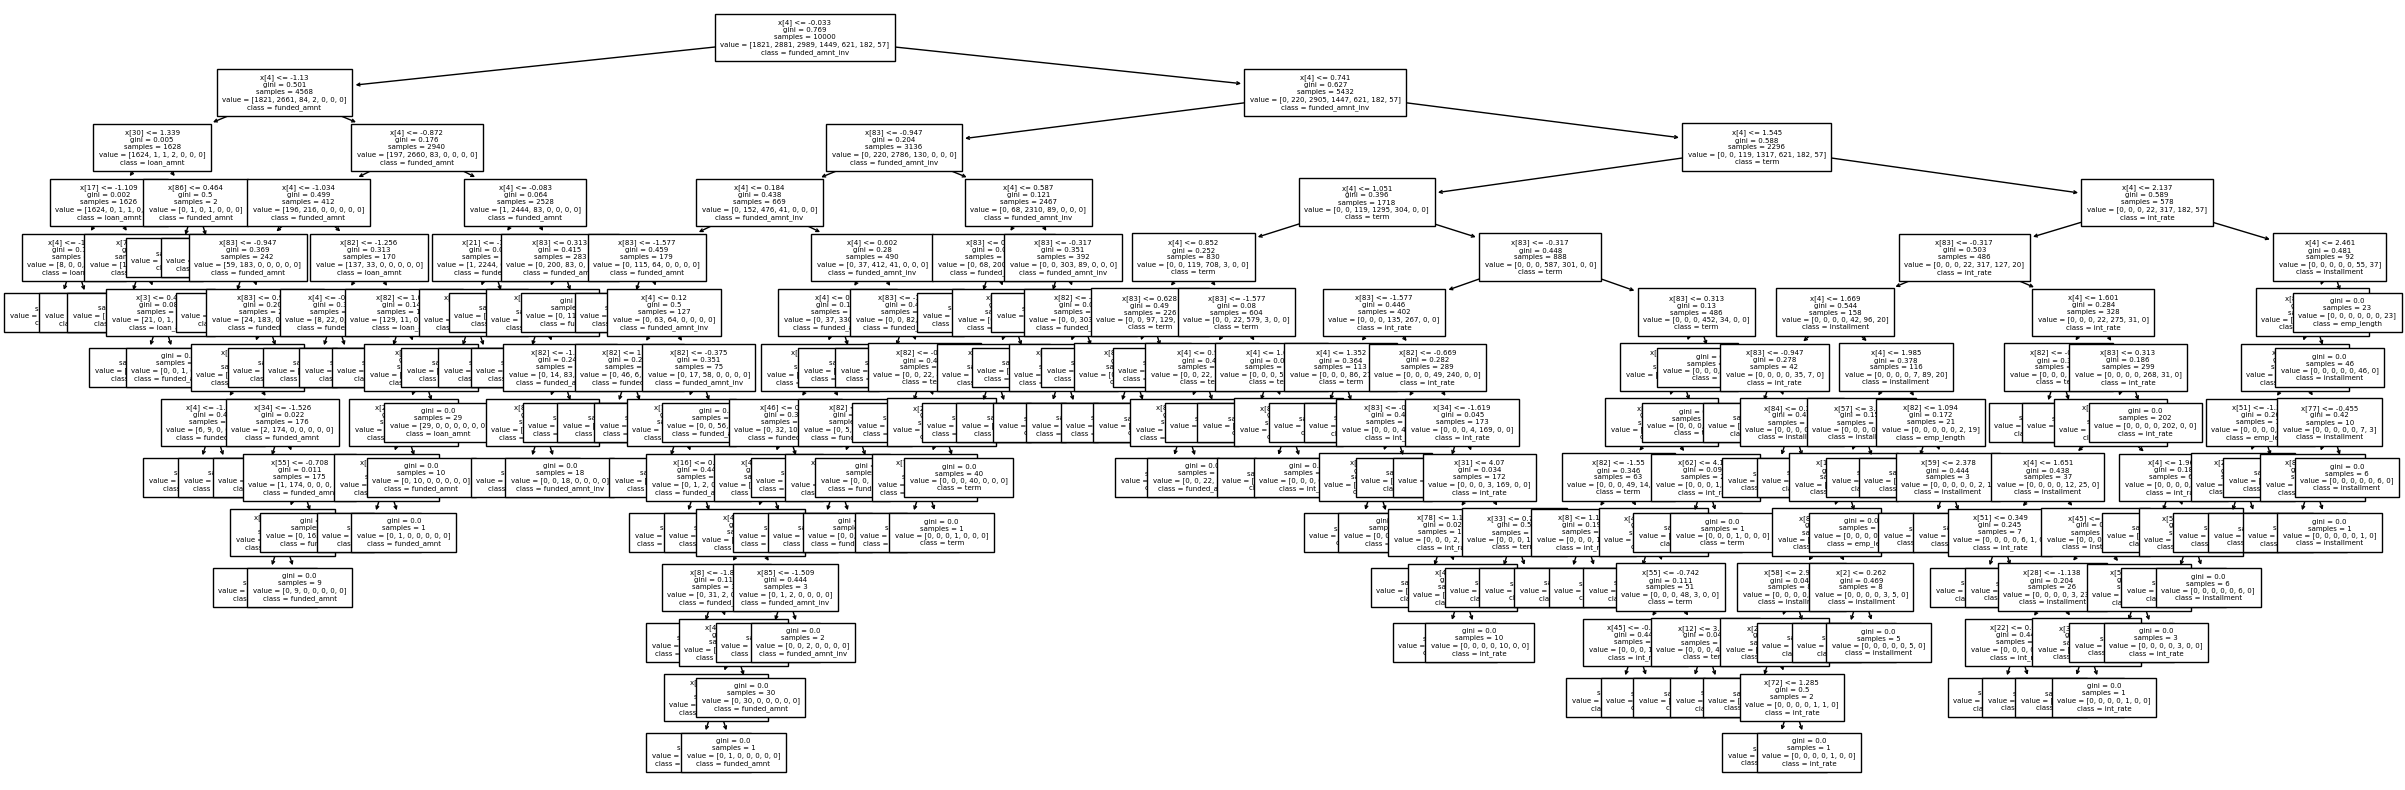

In [38]:
from sklearn.tree import plot_tree


plt.figure(figsize=(30,10))  # set plot size (denoted in inches)
plot_tree(pipelines['DT']['DT'], fontsize=5, class_names=list(X_tr.columns))
plt.show()
